In [1]:
# Import all neccessary libraries

import matplotlib.pyplot as plt
import numpy as np
import math
import random

from astropy.constants import G
from astropy.constants import M_sun
from astropy.constants import au
from astropy import units as u
from scipy.optimize import curve_fit 

%matplotlib inline

In [2]:
def GetSemiMajorAxis(orbital_period):
    """Get the semi-major axis values using the formula from Keplers third law."""
    
    # Using the Keplers third law equation
    semi_mojor_axis_cubed = ((orbital_period * 24 * 3600 * u.second)**2 * 
               G * M_sun / (4*(math.pi)**2)
              ) 
    semi_mojor_axis = (semi_mojor_axis_cubed)**(1/3)
    semi_mojor_axis_au = semi_mojor_axis / (au) * u.au # Converting to astronomical units
    return semi_mojor_axis_au 

# Using the Earth to confirm if the function is working as expected
print(GetSemiMajorAxis(365.25)) 
    

0.9999874090340476 AU


In [3]:
# Simulating five fake planets periods
np.random.seed(1000)
period = np.random.uniform(low=10, high=100000, size=5)
print(period)


[65362.42265061 11509.54424301 95028.78360626 48224.31822879
 87248.72877285]


In [4]:
# Calculating Semi-major axis for each fake planet
fake_planets_axis = GetSemiMajorAxis(period)
print(fake_planets_axis)


[31.75556245  9.97638345 40.75408643 25.92856289 38.49820263] AU


In [5]:
# Generating noise and adding noise to the fake
# planet measurements. The SNR should be equal
# to 10

np.random.seed(1000)

measurement_plus_noise = [axis_value.value + np.random.normal(loc=0, scale=axis_value.value / 10) 
                          for axis_value in fake_planets_axis] * au 
print(measurement_plus_noise)

one_sigma_error = [axis_value.value / 10 for axis_value in fake_planets_axis] * au
print(one_sigma_error)

[4.36840142e+12 1.54034301e+12 6.08118834e+12 4.12878185e+12
 5.58601284e+12] m
[4.75056453e+11 1.49244572e+11 6.09672455e+11 3.87885780e+11
 5.75924914e+11] m


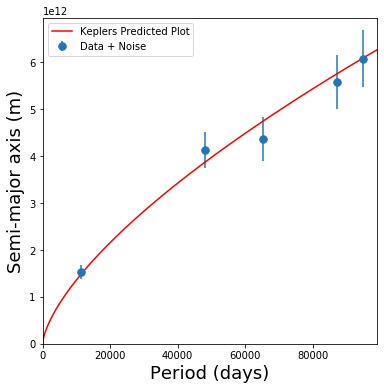

In [6]:
# Plotting datapoints and uncertainties

figsize={'figsize' : (6,6)}
fig = plt.figure(**figsize)
ax = plt.subplot(111)

# Plot errorbars
plt.errorbar(period, 
             measurement_plus_noise.value, 
             one_sigma_error.value, 
             ls='none',  
             marker = '.', 
             markersize = 15,
             label = 'Data + Noise'
             )

plt.xlim(0,)
plt.ylim(0,)
xmin,xmax = ax.get_xlim()

# Using Keplers law for predicted plot
x = np.arange(0, xmax, 100)
y = GetSemiMajorAxis(x).value * au.value
plt.plot(x, y, 
         zorder = 2, 
         color = 'r',
         label = 'Keplers Predicted Plot'
        )

plt.xlabel('Period (days)', fontsize=18)
plt.ylabel('Semi-major axis (m)', fontsize=18)

plt.legend(loc='best')
plt.show()


In [7]:
# Find best fit value for M

T = period
y = measurement_plus_noise.value

def test(T, Predicted_M_sun):
    """Get predicted axis value for each period input."""
    
    axis_predicted = (((T * 24 * 3600)**2 * 
                       G.value * Predicted_M_sun / (4 * (math.pi)**2)))**(1/3)
    return axis_predicted 

# Setting the initial value and curve fitting
param, param_cov = curve_fit(test, T, y, p0=[20000000], sigma=one_sigma_error) 
calculated_value = param[0]
print(calculated_value)

1.9687972188826462e+30


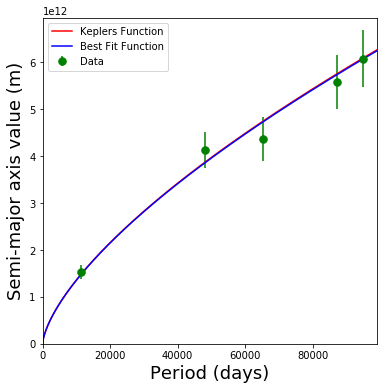

In [8]:
# Using the best fit M value to overlay

figsize={'figsize' : (6,6)}

fig = plt.figure(**figsize)

ax = plt.subplot(111)

# Plotting the data
plt.errorbar(period, 
             measurement_plus_noise.value, 
             one_sigma_error.value, ls='none', 
             marker='.',
             color='green',
             markersize=15,
             label='Data'
            )

plt.xlim(0,)
plt.ylim(0,)

xmin,xmax = ax.get_xlim()

# Plotting Keplers function
x = np.arange(0, xmax, 100)
y = GetSemiMajorAxis(x).value * au.value
plt.plot(x, y, 
         zorder=2, 
         color='r', 
         label='Keplers Function')

# Plotting best fit function
T = np.arange(0, xmax, 100)
plt.plot(T, 
         test(T, param[0]), 
         color='blue',
         label='Best Fit Function')

plt.xlabel('Period (days)', fontsize=18)
plt.ylabel('Semi-major axis value (m)', fontsize=18)

plt.legend(loc='best')
plt.show()

In [9]:
# Compute uncertanity and signal to noise ratio
uncertainity_M = param_cov[0][0]**0.5
print(uncertainity_M)
signal_to_noise_ratio = calculated_value / uncertainity_M
print(signal_to_noise_ratio)


1.4820667339667614e+29
13.284133391302477


In [10]:
error = (M_sun.value - calculated_value) 
print(error)

1.967819645549764e+28


In [11]:
best_fit_values = []
errors_in_best_fit = []
period_values = []
measurement_plus_noise_values = []
one_sigma_error_values = []

np.random.seed(1000)
number_of_times = 1000

for i in range(number_of_times):
    
    T = np.random.uniform(low=10, high=100000, size=5)
    period_values.append(T)
    
    fake_planets_axis = GetSemiMajorAxis(T)
    
    measurement_plus_noise = [axis_value.value + np.random.normal(loc=0, scale=axis_value.value/10) 
                          for axis_value in fake_planets_axis] * au # Introducing noise into the system
    measurement_plus_noise_values.append(measurement_plus_noise)
    
    one_sigma_error = [axis_value.value/10 for axis_value in fake_planets_axis] * au
    one_sigma_error_values.append(one_sigma_error)
    
    y = measurement_plus_noise.value
    param, param_cov = curve_fit(test, T, y, p0=[200000000], sigma=one_sigma_error) # Setting the initial value and doing curve fitting
    best_fit_values.append(param[0])
    errors_in_best_fit .append((param_cov[0][0])**(0.5))

In [12]:
# Checking if values agree can be done by simply checking 
# if the absolute value of the difference between the best fit value
# and the true value is less than the error

def CheckAgreement(measured_value, error, true_value):
    """Check if the measured value agree with the true value within the meausure of uncertainty"""
    return abs(true_value - measured_value) <= error
    
num_agreeing_values = 0
for pos, best_fit_value in enumerate(best_fit_values):
    error = errors_in_best_fit[pos]
    if CheckAgreement(best_fit_value, error, M_sun.value):
        num_agreeing_values += 1
        
print(num_agreeing_values) 
print(f'The fraction of agreement is {num_agreeing_values / number_of_times}.')   

612
The fraction of agreement is 0.612.


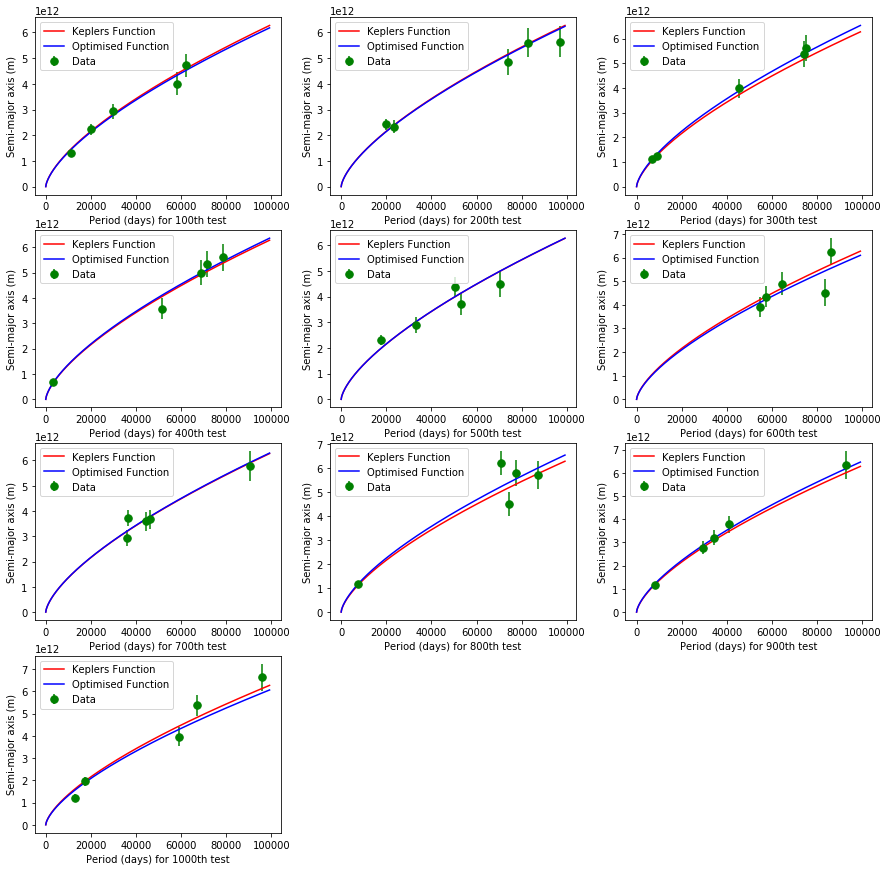

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

figsize={'figsize' : (15,15)}
fig = plt.figure(**figsize)

gs1 = gridspec.GridSpec(4, 3)
Figures = ["Figure " + str(i) for i in range(1, 11)]
axs = []
for c, num in zip(Figures, range(1,11)):
    axs.append(fig.add_subplot(gs1[num - 1]))
    plt.errorbar(period_values[num*100-1], 
             measurement_plus_noise_values[num*100-1].value, 
             one_sigma_error_values[num*100-1].value, 
             ls='none', 
             marker='.',
             color='green',
             markersize=15,
             label='Data'
            )
    
    # Plotting the True values
    x = np.arange(0, xmax, 100)
    y = GetSemiMajorAxis(x).value * au.value
    plt.plot(x, y, 
             zorder=2, 
             color='r', 
             label='Keplers Function')
    
    # Plotting the best fit plot
    T = np.arange(0, xmax, 100)
    plt.plot(T, 
             test(T, best_fit_values[num*100-1]), 
             color='blue',
             label='Optimised Function')

    plt.xlabel(f'Period (days) for {num*100}th test', fontsize=10)
    plt.ylabel('Semi-major axis (m)', fontsize=10)
    plt.legend(loc='best')

    

plt.show()

In [14]:
median_best_fit = np.median(best_fit_values)
print(median_best_fit)

1.9783386587116104e+30


In [15]:
# As the old adage goes, Trust but verify! Hence, just confirm if the median in indeed correct

best_fit_values_sorted = sorted(best_fit_values)
(best_fit_values_sorted[499] + best_fit_values_sorted[500])/2

1.9783386587116104e+30

In [16]:
measurement_and_error = [[best_fit_value, errors_in_best_fit[pos]] for pos, best_fit_value in enumerate(best_fit_values)]
measurement_and_error_sorted = sorted(measurement_and_error, key=lambda l:l[0])
(measurement_and_error_sorted[499][0] + measurement_and_error_sorted[500][0]) / 2

print(measurement_and_error_sorted[499][0])
print(measurement_and_error_sorted[500][0])

error_in_median = (measurement_and_error_sorted[499][1]**2 + measurement_and_error_sorted[500][1]**2)**(0.5)
print(error_in_median)

CheckAgreement(median_best_fit, error_in_median, M_sun.value)

1.9777810787635717e+30
1.9788962386596488e+30
3.8062409178806086e+29


True

The best fit value agree with the true value within the degree of uncertainty

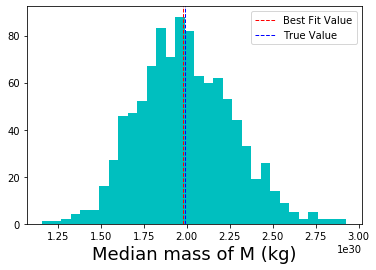

In [17]:
# Determinning the number of bins

n = len(best_fit_values_sorted)
# range_value = best_fit_values_sorted[-1] - best_fit_values_sorted[0]
number_of_intervals = (n)**(0.5)
number_of_bins = math.ceil(number_of_intervals) 
number_of_bins

x = best_fit_values_sorted 

# Plotting Histogram
plt.hist(x, 
         bins = number_of_bins, 
         color='c'
        )

# Plotting best fit
plt.axvline(median_best_fit, 
            color='red', 
            linestyle='dashed', 
            linewidth=1,
            label = 'Best Fit Value'
           )

# Plotting true value
plt.axvline(M_sun.value, 
            color='blue', 
            linestyle='dashed', 
            linewidth=1,
            label = 'True Value'
           )

plt.xlabel('Median mass of M (kg)', fontsize=18)
plt.legend(loc='best')

plt.show()

The distribution appears to be gaussian.

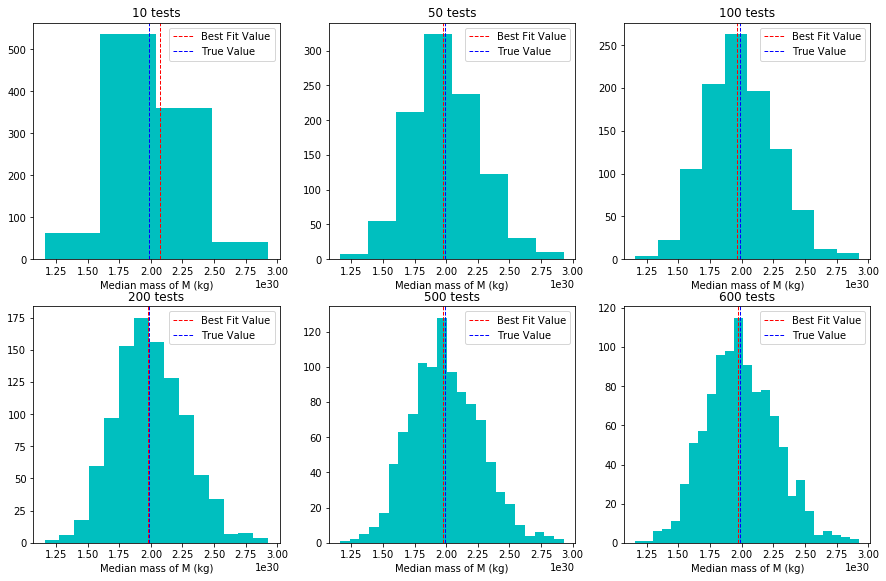

In [18]:
figsize={'figsize' : (15,20)}
fig = plt.figure(**figsize)

gs1 = gridspec.GridSpec(4, 3)
Figures = ["Figure " + str(i) for i in range(1, 7)]
axs = []
"""
for c, num in zip(Figures, range(1,11)):
    axs.append(fig.add_subplot(gs1[num - 1]))
"""    
# Question 12b
tests = [10, 50, 100, 200, 500, 600]
for num, number_of_times in enumerate(tests):  
    
    best_fit_values = []
    errors_in_best_fit = []
    period_values = []
    measurement_plus_noise_values = []
    one_sigma_error_values = []

    np.random.seed(1000)

    for i in range(number_of_times):

        T = np.random.uniform(low=10, high=100000, size=5)
        period_values.append(T)

        fake_planets_axis = GetSemiMajorAxis(T)

        measurement_plus_noise = [axis_value.value + np.random.normal(loc=0, scale=axis_value.value/10) 
                              for axis_value in fake_planets_axis] * au # Introducing noise into the system
        measurement_plus_noise_values.append(measurement_plus_noise)

        one_sigma_error = [axis_value.value/10 for axis_value in fake_planets_axis] * au
        one_sigma_error_values.append(one_sigma_error)

        y = measurement_plus_noise.value
        param, param_cov = curve_fit(test, T, y, p0=[200000000], sigma=one_sigma_error) # Setting the initial value and doing curve fitting
        best_fit_values.append(param[0])
        errors_in_best_fit .append((param_cov[0][0])**(0.5))

    median_best_fit = np.median(best_fit_values)
    
    n = len(best_fit_values)
    number_of_intervals = (n)**(0.5)
    number_of_bins = math.ceil(number_of_intervals) 
    number_of_bins
    
    x = best_fit_values_sorted 
    
    axs.append(fig.add_subplot(gs1[num]))
    # Plotting Histogram
    plt.hist(x, 
             bins = number_of_bins, 
             color='c'
            )

    # Plotting best fit
    plt.axvline(median_best_fit, 
                color='red', 
                linestyle='dashed', 
                linewidth=1,
                label = 'Best Fit Value'
               )

    # Plotting true value
    plt.axvline(M_sun.value, 
                color='blue', 
                linestyle='dashed', 
                linewidth=1,
                label = 'True Value'
               )
    plt.title(f'{tests[num]} tests')

    plt.xlabel('Median mass of M (kg)', fontsize=10)
    plt.legend(loc='best')

plt.show()

As the number of tests increase, the best value moves very close to the actual value. It seems not to have a great effect on the 
shape of the gaussianess of the distribution

This session is for a signal to noise ratio of 1


/opt/workshop/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':
/opt/workshop/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


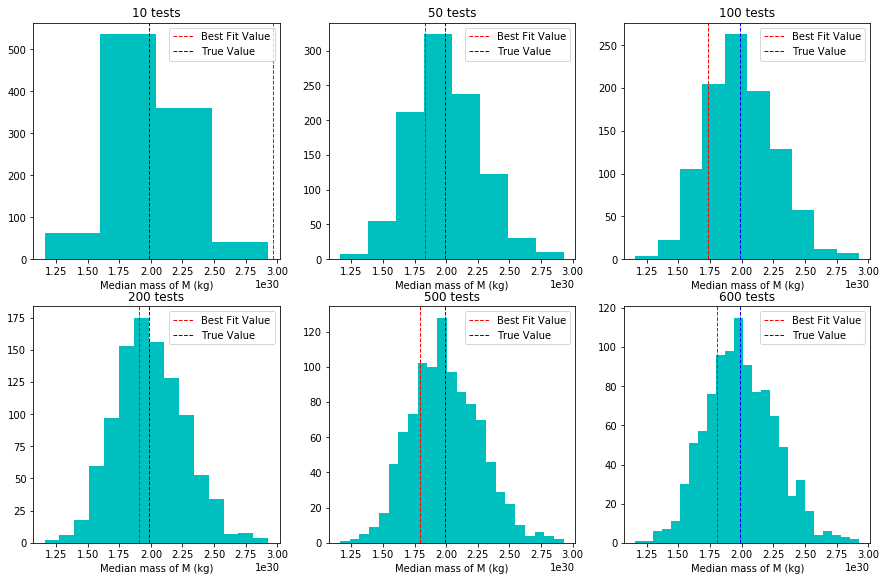

Another session is about to begin .........
This session is for a signal to noise ratio of 3


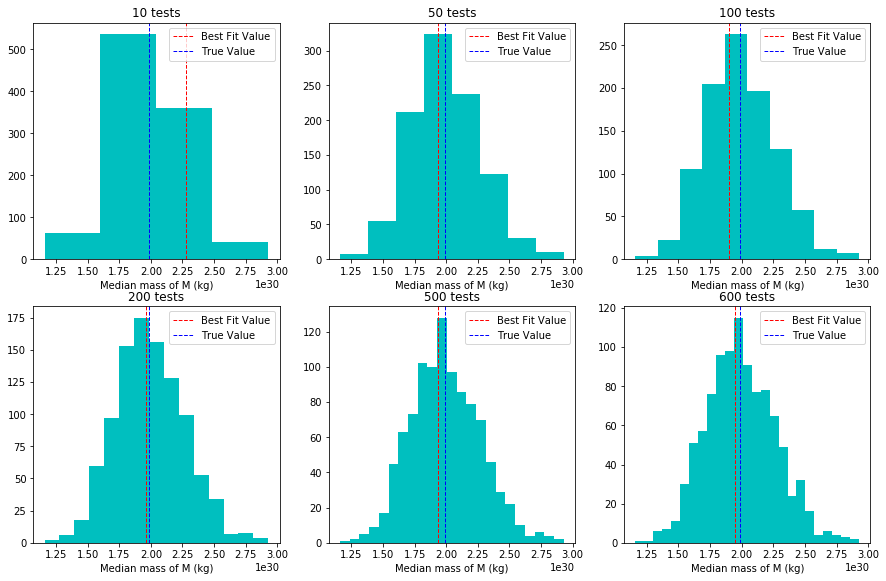

Another session is about to begin .........
This session is for a signal to noise ratio of 5


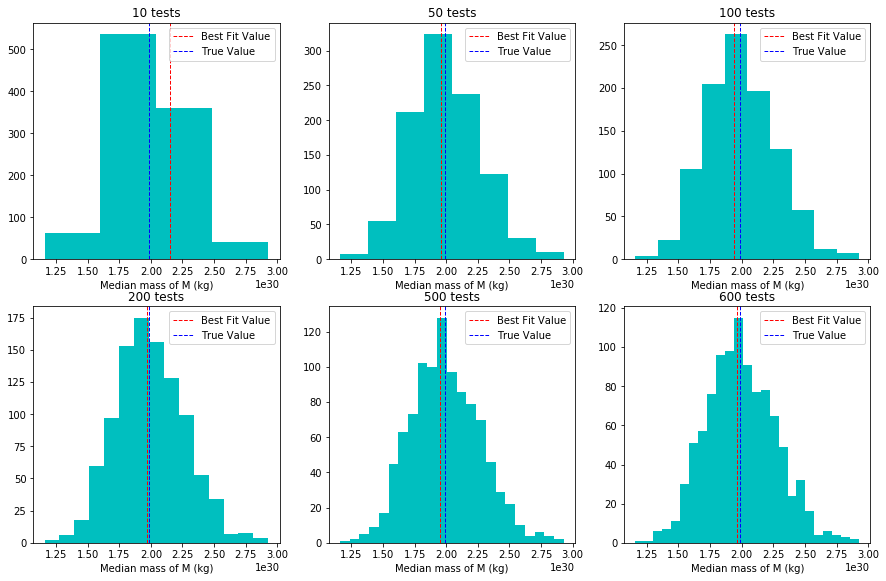

Another session is about to begin .........
This session is for a signal to noise ratio of 100


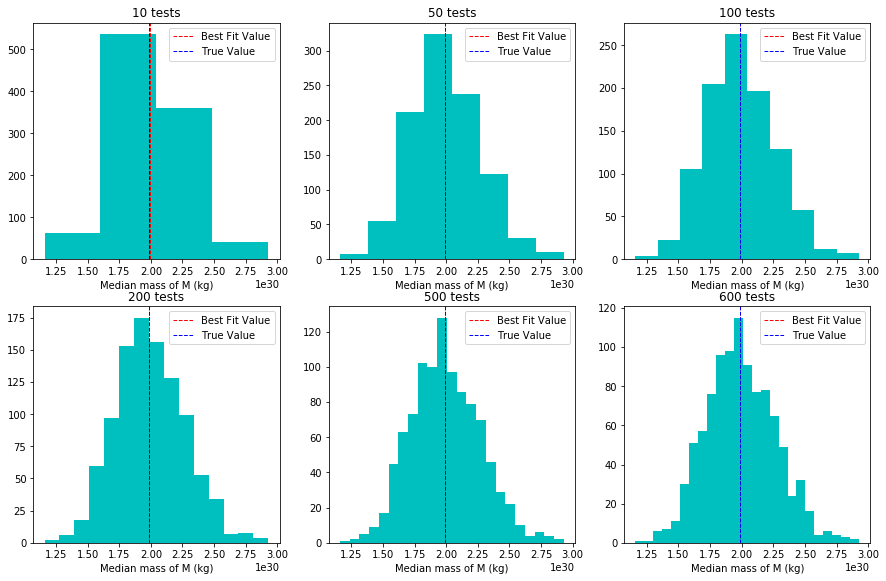

All sessions have been completed! You are invited to check the results.


In [19]:
SNR = [1, 3, 5, 100]

for snr in SNR: 
    figsize={'figsize' : (15,20)}
    fig = plt.figure(**figsize)

    gs1 = gridspec.GridSpec(4, 3)
    Figures = ["Figure " + str(i) for i in range(1, 7)]
    axs = []
    print(f'This session is for a signal to noise ratio of {snr}')
    
    tests = [10, 50, 100, 200, 500, 600]
    for num, number_of_times in enumerate(tests):  

        best_fit_values = []
        errors_in_best_fit = []
        period_values = []
        measurement_plus_noise_values = []
        one_sigma_error_values = []

        np.random.seed(1000)

        for i in range(number_of_times):

            T = np.random.uniform(low=10, high=100000, size=5)
            period_values.append(T)

            fake_planets_axis = GetSemiMajorAxis(T)

            measurement_plus_noise = [axis_value.value + np.random.normal(loc=0, scale=axis_value.value / snr) 
                                  for axis_value in fake_planets_axis] * au 
            measurement_plus_noise_values.append(measurement_plus_noise)

            one_sigma_error = [axis_value.value/snr for axis_value in fake_planets_axis] * au
            one_sigma_error_values.append(one_sigma_error)

            y = measurement_plus_noise.value
            param, param_cov = curve_fit(test, T, y, p0=[200000000], sigma=one_sigma_error)
            best_fit_values.append(param[0])
            errors_in_best_fit .append((param_cov[0][0])**(0.5))

        median_best_fit = np.median(best_fit_values)

        n = len(best_fit_values)
        number_of_intervals = (n)**(0.5)
        number_of_bins = math.ceil(number_of_intervals) 
        number_of_bins
        
        x = best_fit_values_sorted 

        axs.append(fig.add_subplot(gs1[num]))
        # Plotting Histogram
        plt.hist(x, 
                 bins = number_of_bins, 
                 color='c'
                )

        # Plotting best fit
        plt.axvline(median_best_fit, 
                    color='red', 
                    linestyle='dashed', 
                    linewidth=1,
                    label = 'Best Fit Value'
                   )

        # Plotting true value
        plt.axvline(M_sun.value, 
                    color='blue', 
                    linestyle='dashed', 
                    linewidth=1,
                    label = 'True Value'
                   )
        plt.title(f'{tests[num]} tests')

        plt.xlabel('Median mass of M (kg)', fontsize=10)
        plt.legend(loc='best')

    plt.show()
        
        
    if snr != SNR[-1]:
        print('Another session is about to begin .........')
    else:
        print('All sessions have been completed! You are invited to check the results.')

A higher signal to noise ratio results in a more accurate measurement of the mass of the sun. This is by 
the red line (best fit value) moving closer to the blue line (actual value) such that the blue line superimposes the red line for an signal to noise ratio of 100. Therefore, it is more significant to have a higher signal-to-noise ratio than to perform more tests. A higher signal to noise 
ratio ensures that the calculated semi major axis values for random planets are very close to the actual and as the noise will be very small. As a result, the best fit value is more accurate.